In [43]:
import pymysql
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from scipy import stats
import datetime
from itertools import product
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
connection = pymysql.connect(host='80.78.255.167',
                             user='igorsber',
                             password='sber123',                             
                             db='sberbank',
                             cursorclass=pymysql.cursors.DictCursor)

In [3]:
data_sber = pd.DataFrame(columns=['report_date', 'amount_rur', 'amount_usd', 'total_amount'])
data_vtb = pd.DataFrame(columns=['report_date', 'amount_rur', 'amount_usd', 'total_amount'])
data_unic = pd.DataFrame(columns=['report_date', 'amount_rur', 'amount_usd', 'total_amount'])

Из базы получаю три датасета (для всех трех account_id = 42301):


sql_sber - данные по сберу, bank_id=1481

sql_vtb - данные по втб, bank_id=1000

sql_unic - данные по юникредиту bank_id=1

In [4]:
with connection.cursor() as cursor:
       
    sql_sber = "SELECT * FROM ru_bank_balance_sheet where bank_id=1481 and account_id like '42301%'"
    cursor.execute(sql_sber)
    for row in cursor:
        data_sber = data_sber.append(row, ignore_index=True)
        
    sql_vtb = "SELECT * FROM ru_bank_balance_sheet where bank_id=1000 and account_id like '42301%'"
    cursor.execute(sql_vtb)
    for row in cursor:
        data_vtb = data_vtb.append(row, ignore_index=True)
        
    sql_unic = "SELECT * FROM ru_bank_balance_sheet where bank_id=1 and account_id like '42301%'"
    cursor.execute(sql_unic)
    for row in cursor:
        data_unic = data_unic.append(row, ignore_index=True)

Группирую по месяцам и суммирую amount_rur и amount_usd с поправкой на курс. 

In [5]:
data_sber = data_sber.drop(['account_id','bank_id'], axis=1)
data_vtb = data_vtb.drop(['account_id','bank_id'], axis=1)
data_unic = data_unic.drop(['account_id','bank_id'], axis=1)

data_sber = data_sber.groupby('report_date').sum()[:117]
data_vtb = data_vtb.groupby('report_date').sum()[:117]
data_unic = data_unic.groupby('report_date').sum()[:117]

usd_to_rur = 65.27
data_sber['total_amount'] = data_sber['amount_rur'] + usd_to_rur * data_sber['amount_usd']
data_vtb['total_amount'] = data_vtb['amount_rur'] + usd_to_rur * data_vtb['amount_usd']
data_unic['total_amount'] = data_unic['amount_rur'] + usd_to_rur * data_unic['amount_usd']

Строю 3 временных ряда

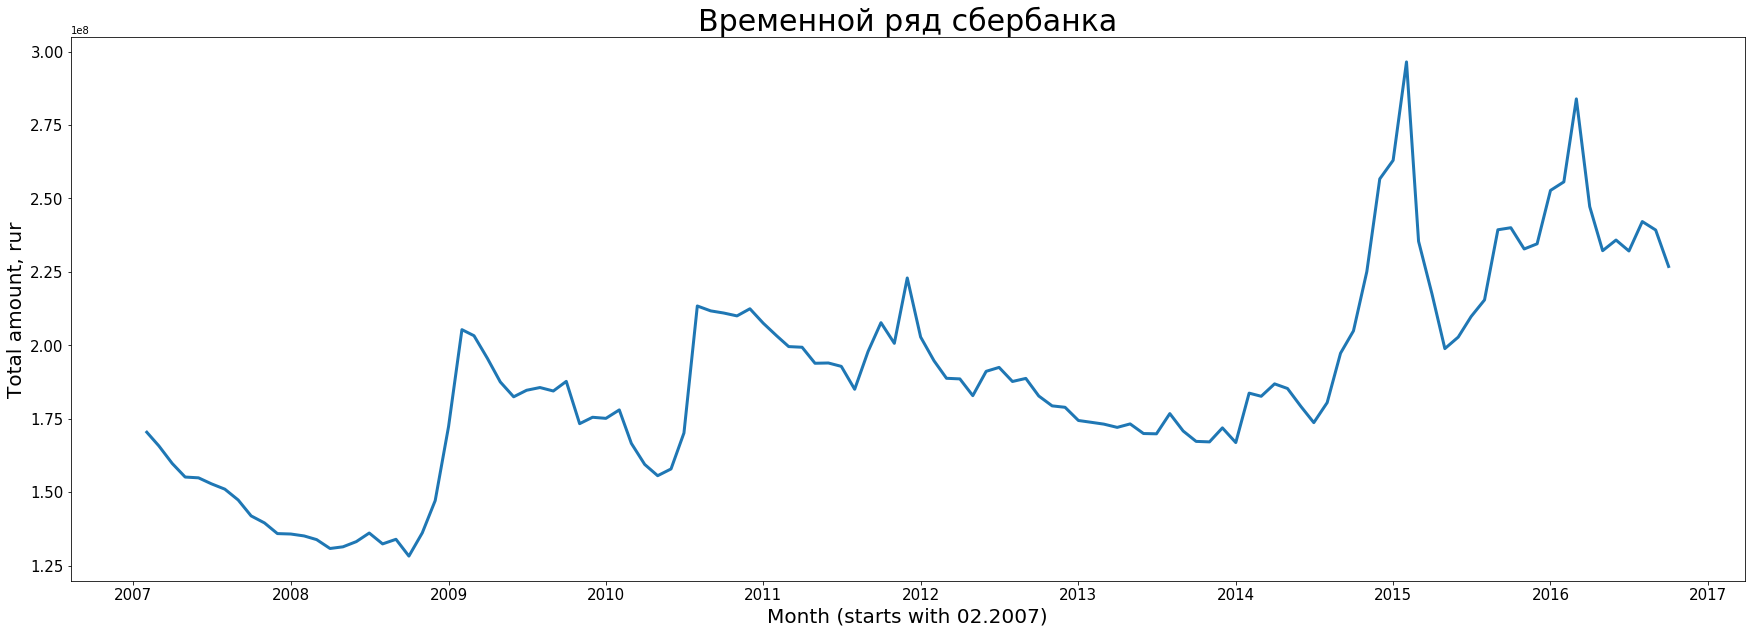

In [6]:
rcParams['figure.figsize'] = 30, 10
data_sber.total_amount.plot(fontsize=15, lw=3);
plt.xlabel('Month (starts with 02.2007)', fontsize=20);
plt.ylabel('Total amount, rur', fontsize=20);
plt.title('Временной ряд сбербанка', fontsize=30);

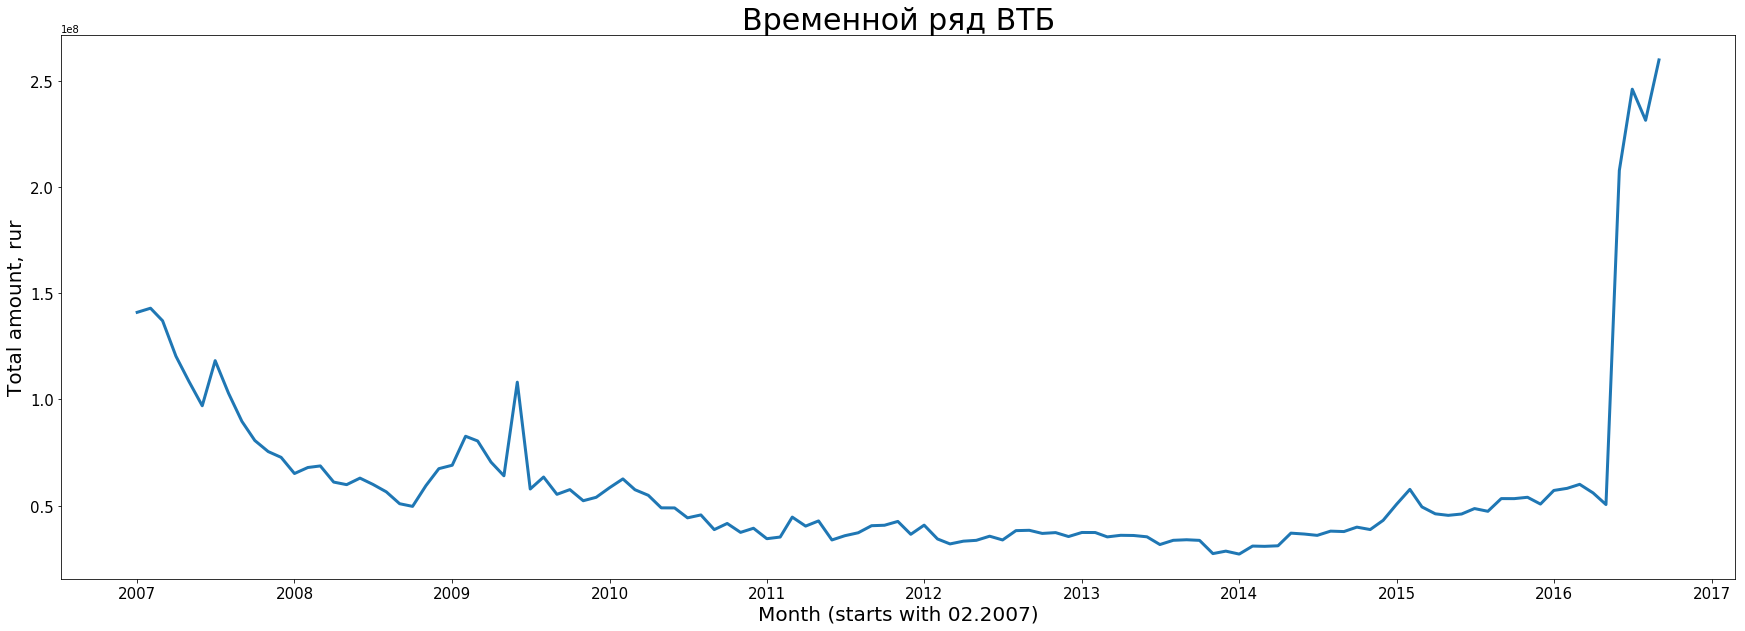

In [7]:
rcParams['figure.figsize'] = 30, 10
data_vtb.total_amount.plot(fontsize=15, lw=3);
plt.xlabel('Month (starts with 02.2007)', fontsize=20);
plt.ylabel('Total amount, rur', fontsize=20);
plt.title('Временной ряд ВТБ', fontsize=30);

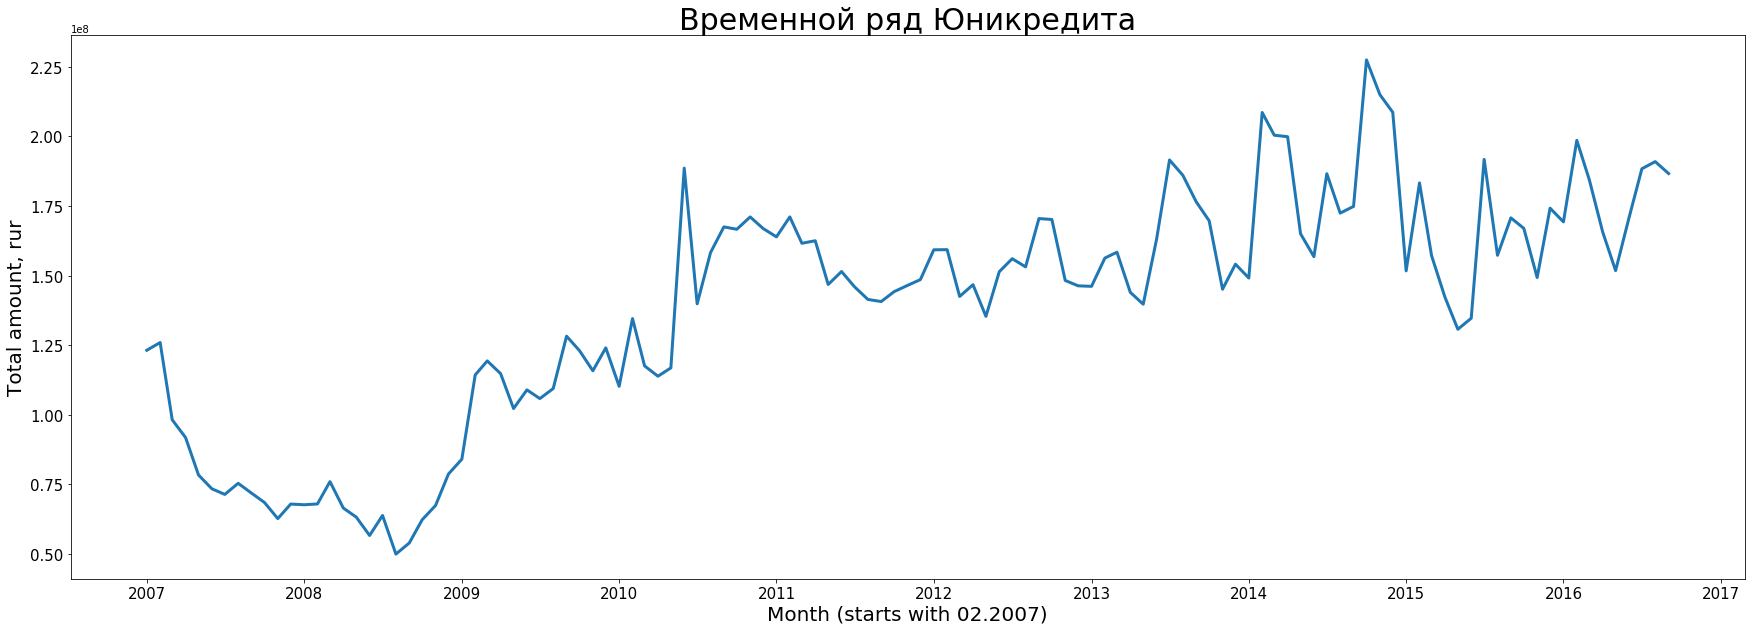

In [8]:
rcParams['figure.figsize'] = 30, 10
data_unic.total_amount.plot(fontsize=15, lw=3);
plt.xlabel('Month (starts with 02.2007)', fontsize=20);
plt.ylabel('Total amount, rur', fontsize=20);
plt.title('Временной ряд Юникредита', fontsize=30);

Во всех трех временных рядах виден тренд, сезонность. Посмотрим на STL-декомпозицию этих рядов, а также проверим гипотезу о НЕстационарности каждого ряда критерием Дики-Фуллера.

In [9]:
data_sber.index = pd.DatetimeIndex(data_sber.index)
data_vtb.index = pd.DatetimeIndex(data_vtb.index)
data_unic.index = pd.DatetimeIndex(data_unic.index)

Сбер: 
Критерий Дики-Фуллера: p=0.500223 

STL:


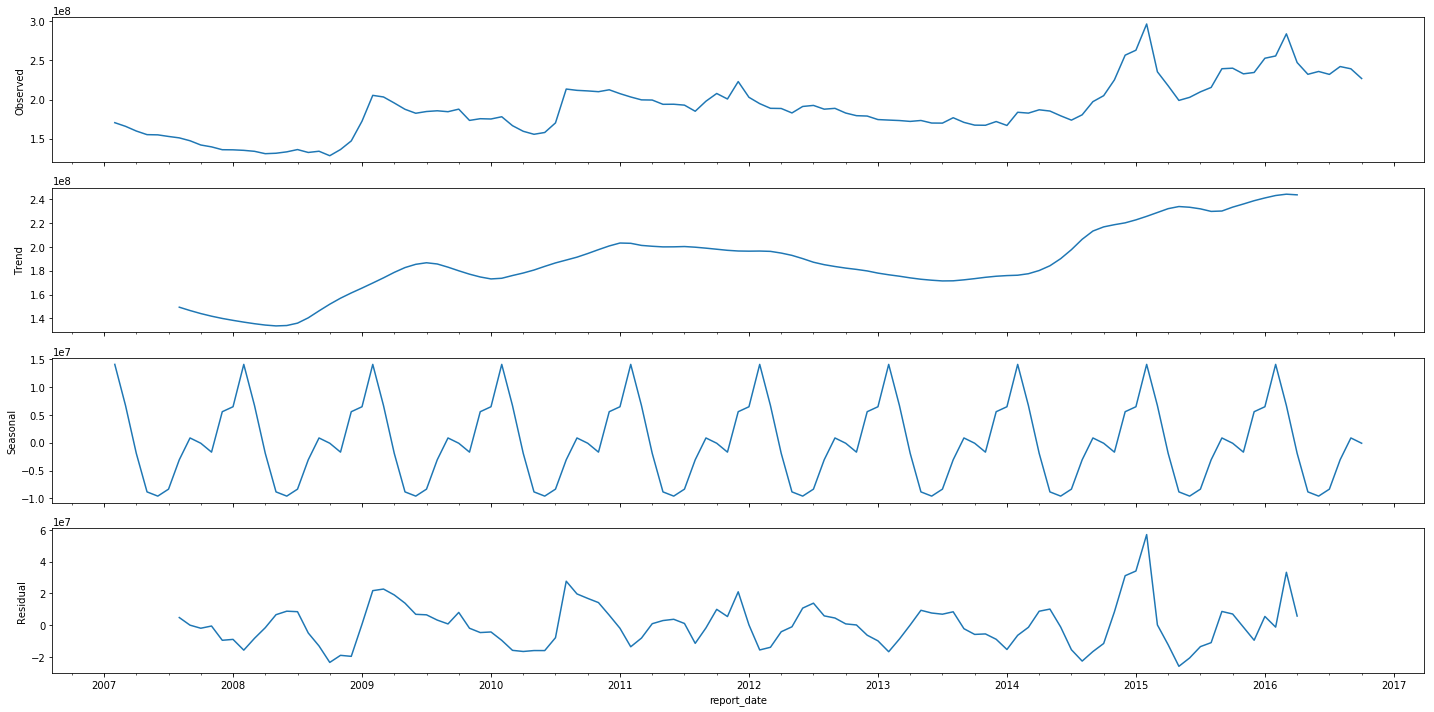

In [10]:
rcParams['figure.figsize'] = 20, 10
sm.tsa.seasonal_decompose(data_sber.total_amount).plot();
print("Сбер: \nКритерий Дики-Фуллера: p=%f \n\nSTL:" % sm.tsa.stattools.adfuller(data_sber.total_amount)[1])

ВТБ: 
Критерий Дики-Фуллера: p=0.950387 

STL:


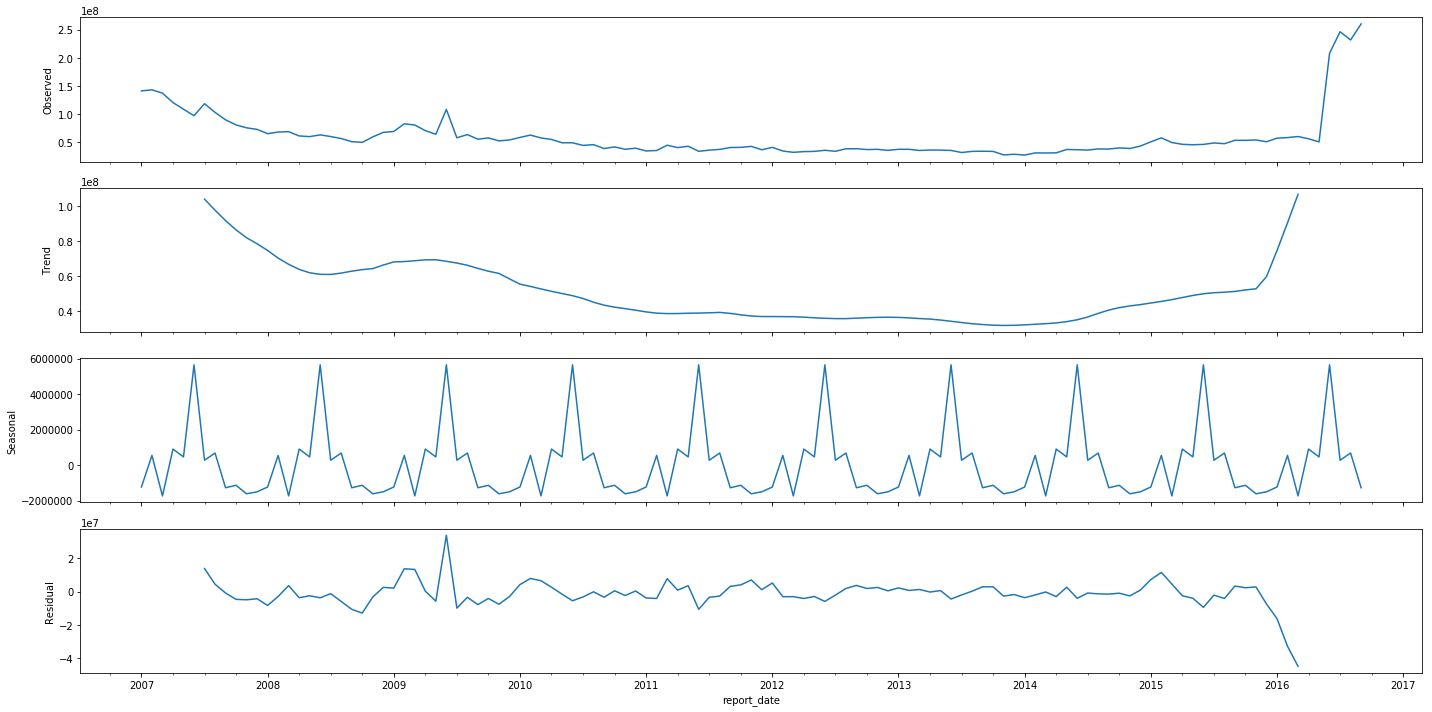

In [11]:
sm.tsa.seasonal_decompose(data_vtb.total_amount).plot()
print("ВТБ: \nКритерий Дики-Фуллера: p=%f \n\nSTL:" % sm.tsa.stattools.adfuller(data_vtb.total_amount)[1])

Юникредит: 
Критерий Дики-Фуллера: p=0.367593 

STL:


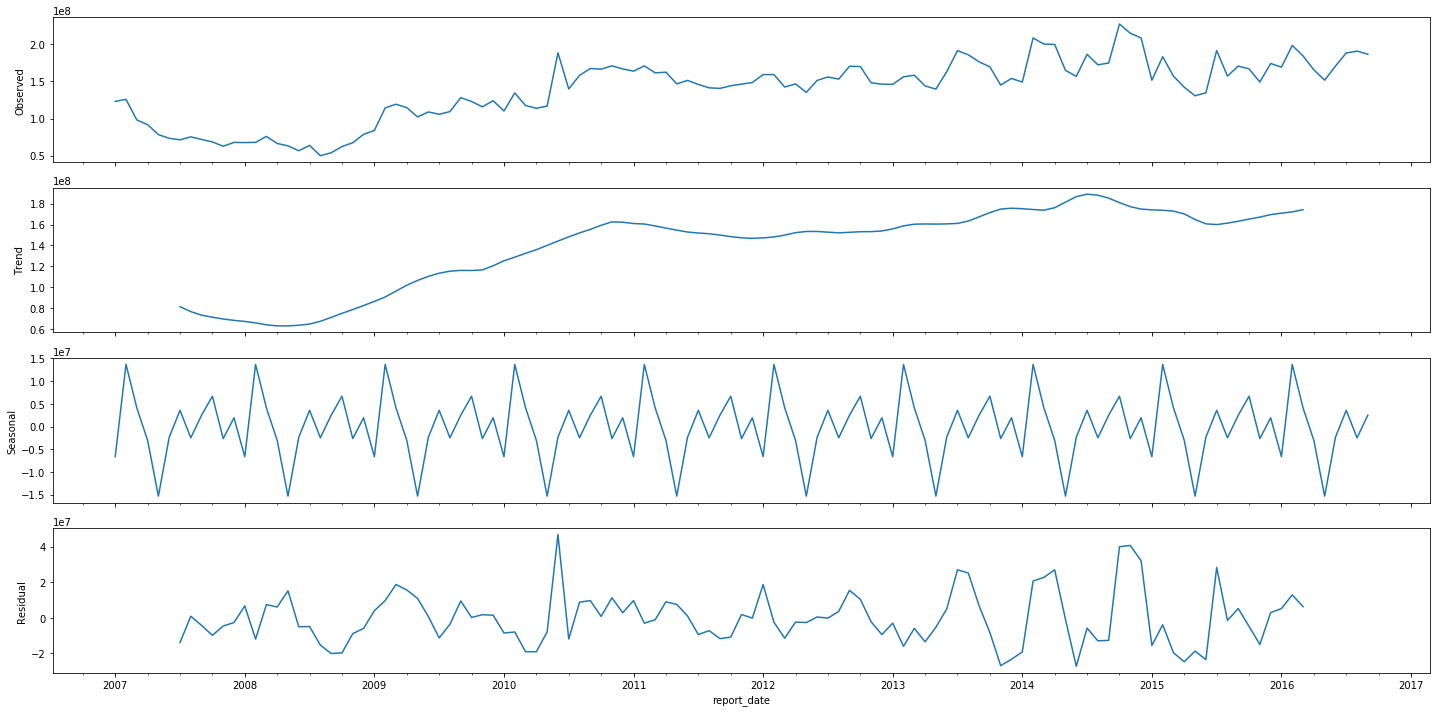

In [12]:
rcParams['figure.figsize'] = 20, 10
sm.tsa.seasonal_decompose(data_unic.total_amount).plot()
print("Юникредит: \nКритерий Дики-Фуллера: p=%f \n\nSTL:"  % sm.tsa.stattools.adfuller(data_unic.total_amount)[1])

Гипотезу о нестационарности не можем отвергнуть ни у одного из рядов. Попробуем применить логарифмирование.

Сбер: 
Критерий Дики-Фуллера после логарифмирования: p=0.531192


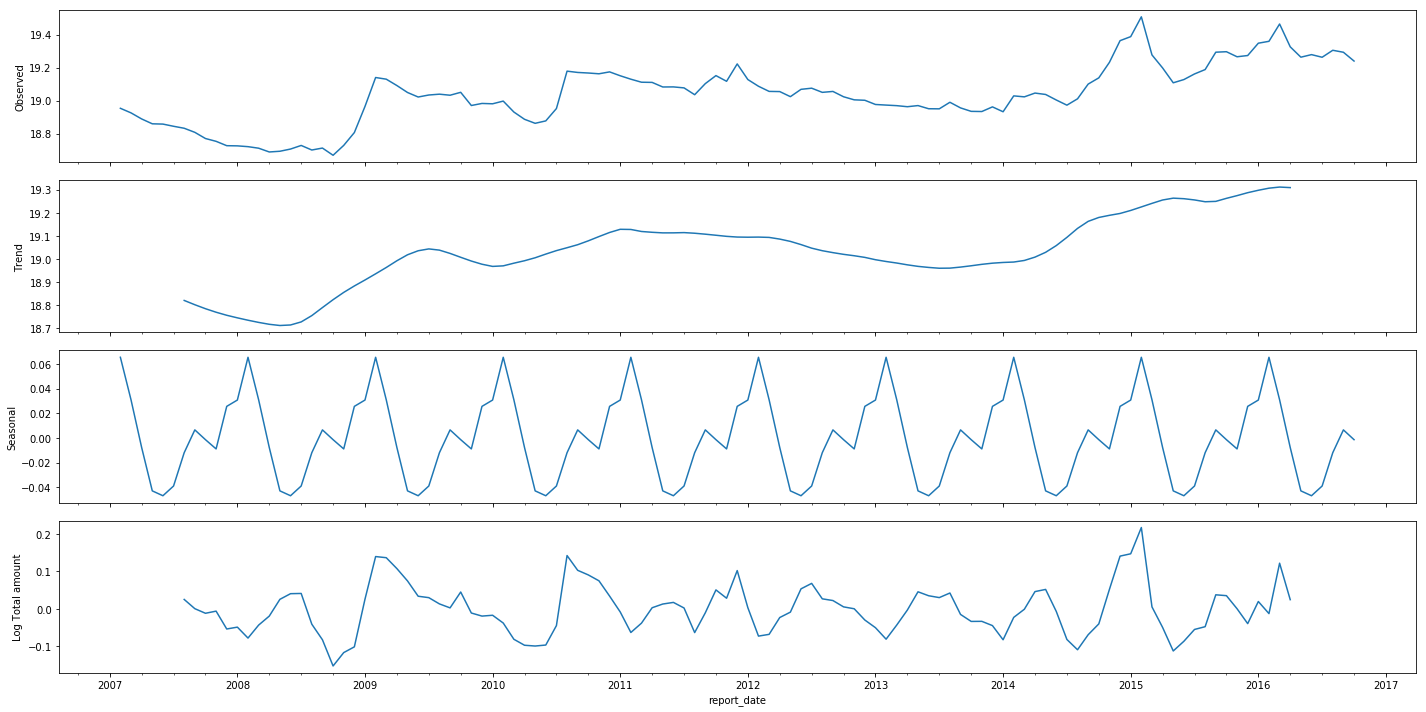

In [13]:
data_sber['total_amount_log'] = data_sber['total_amount'].apply(lambda x: np.log(x))

rcParams['figure.figsize'] = 20, 10
sm.tsa.seasonal_decompose(data_sber.total_amount_log).plot()
plt.ylabel('Log Total amount')
print("Сбер: \nКритерий Дики-Фуллера после логарифмирования: p=%f" 
      % sm.tsa.stattools.adfuller(data_sber.total_amount_log)[1])

ВТБ: 
Критерий Дики-Фуллера после логарифмирования: p=0.668615


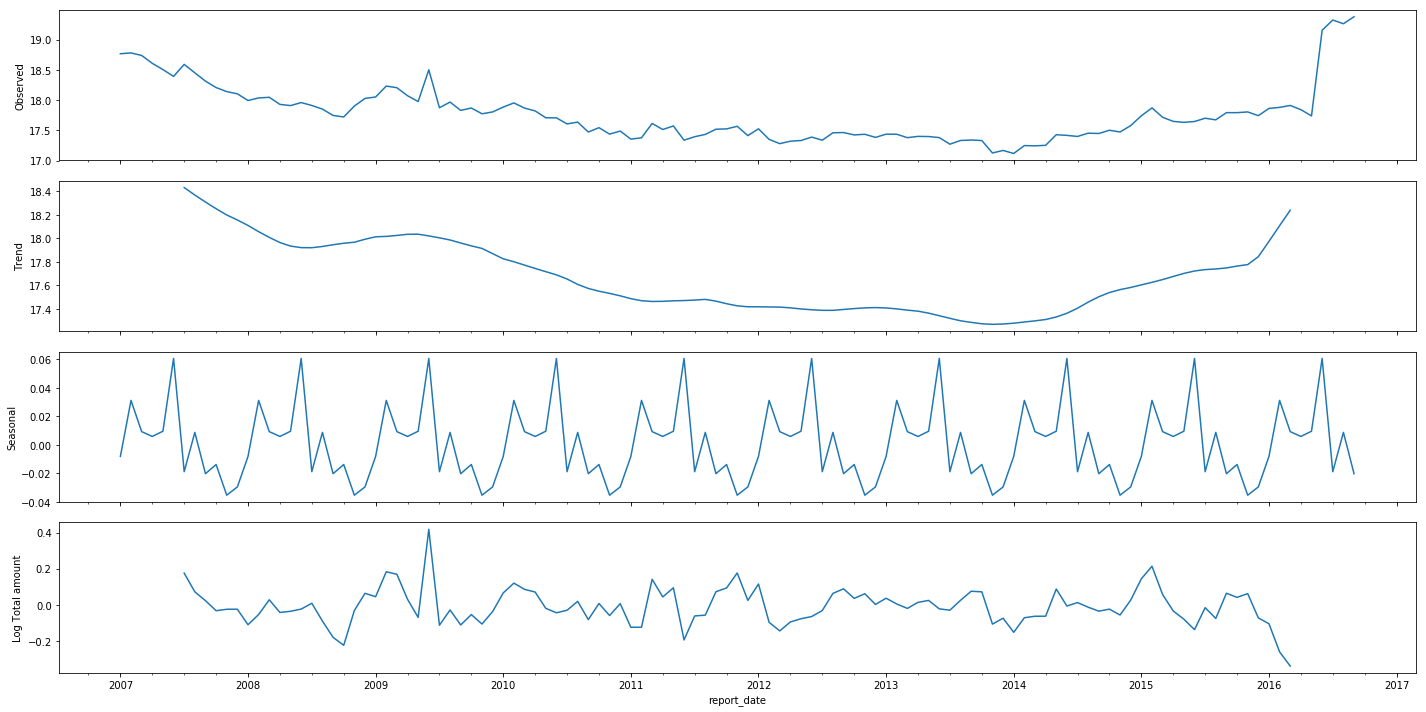

In [14]:
data_vtb['total_amount_log'] = data_vtb['total_amount'].apply(lambda x: np.log(x))
rcParams['figure.figsize'] = 20, 10
sm.tsa.seasonal_decompose(data_vtb.total_amount_log).plot()
plt.ylabel('Log Total amount')
print("ВТБ: \nКритерий Дики-Фуллера после логарифмирования: p=%f" 
      % sm.tsa.stattools.adfuller(data_vtb.total_amount_log)[1])

Юникредит: 
Критерий Дики-Фуллера после логарифмирования: p=0.610302


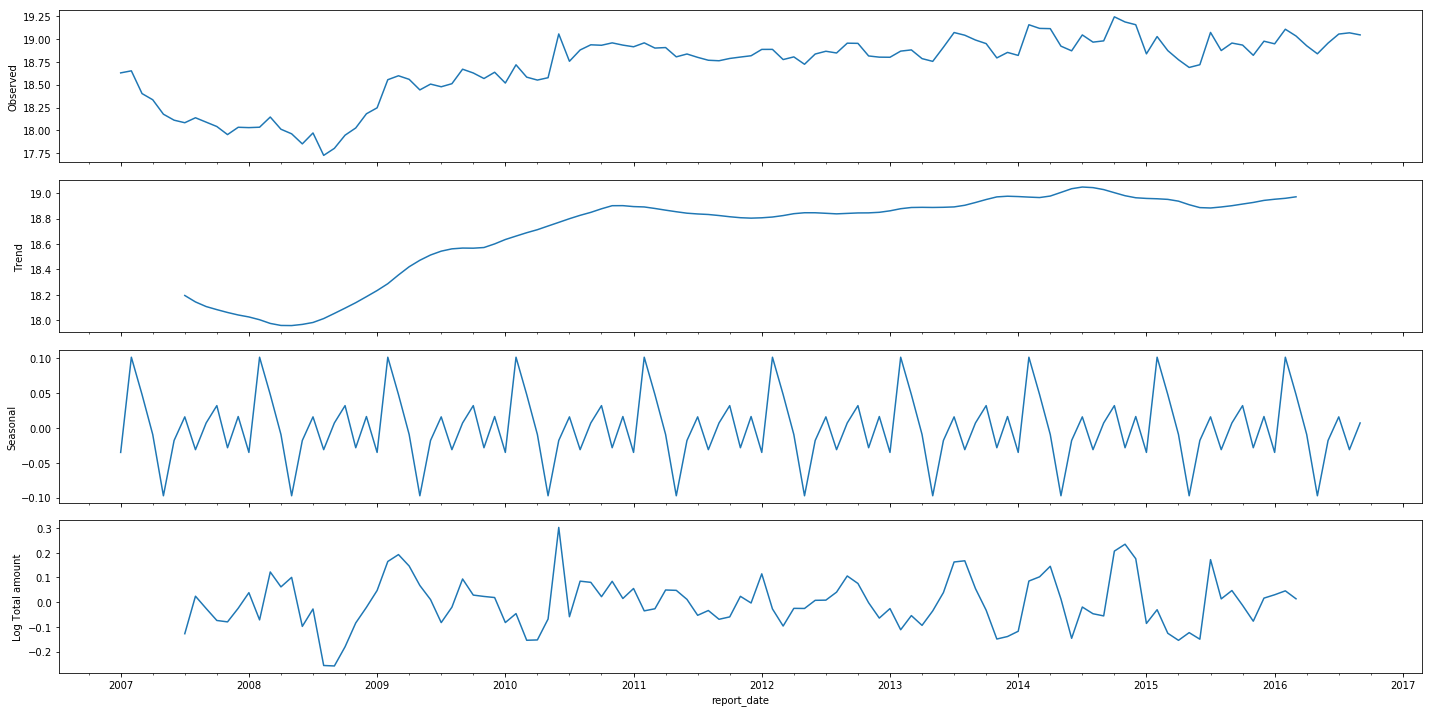

In [15]:
data_unic['total_amount_log'] = data_unic['total_amount'].apply(lambda x: np.log(x))
rcParams['figure.figsize'] = 20, 10
sm.tsa.seasonal_decompose(data_unic.total_amount_log).plot()
plt.ylabel('Log Total amount')
print("Юникредит: \nКритерий Дики-Фуллера после логарифмирования: p=%f" 
      % sm.tsa.stattools.adfuller(data_unic.total_amount_log)[1])

По-прежнему, гипотезу о нестационарности отвергнуть не можем ни в одном из трех случаев. Используем сезонное дифференцирование. Как хорошо видно из графиков, шаг сезонного дифференцирования возьмем равным 4.

Сбер: 
Критерий Дики-Фуллера после логарифмирования и сезонного дифференцирования: p=0.027673


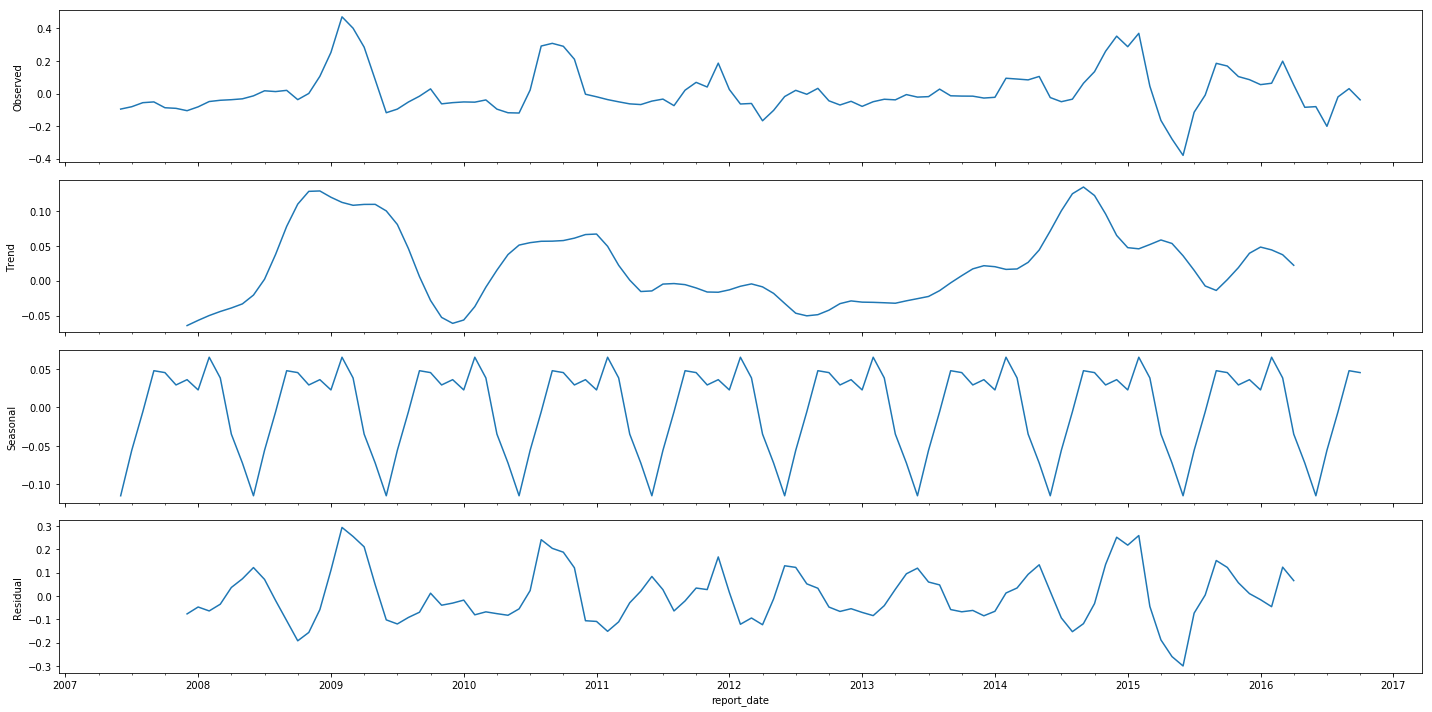

In [16]:
data_sber['total_amount_log_diff'] = data_sber.total_amount_log - data_sber.total_amount_log.shift(4)
rcParams['figure.figsize'] = 20, 10
sm.tsa.seasonal_decompose(data_sber.total_amount_log_diff.iloc[4:]).plot()
print("Сбер: \nКритерий Дики-Фуллера после логарифмирования и сезонного дифференцирования: p=%f" 
      % sm.tsa.stattools.adfuller(data_sber.total_amount_log_diff[4:])[1])

Критерий Дики-Фуллера: p=0.800262


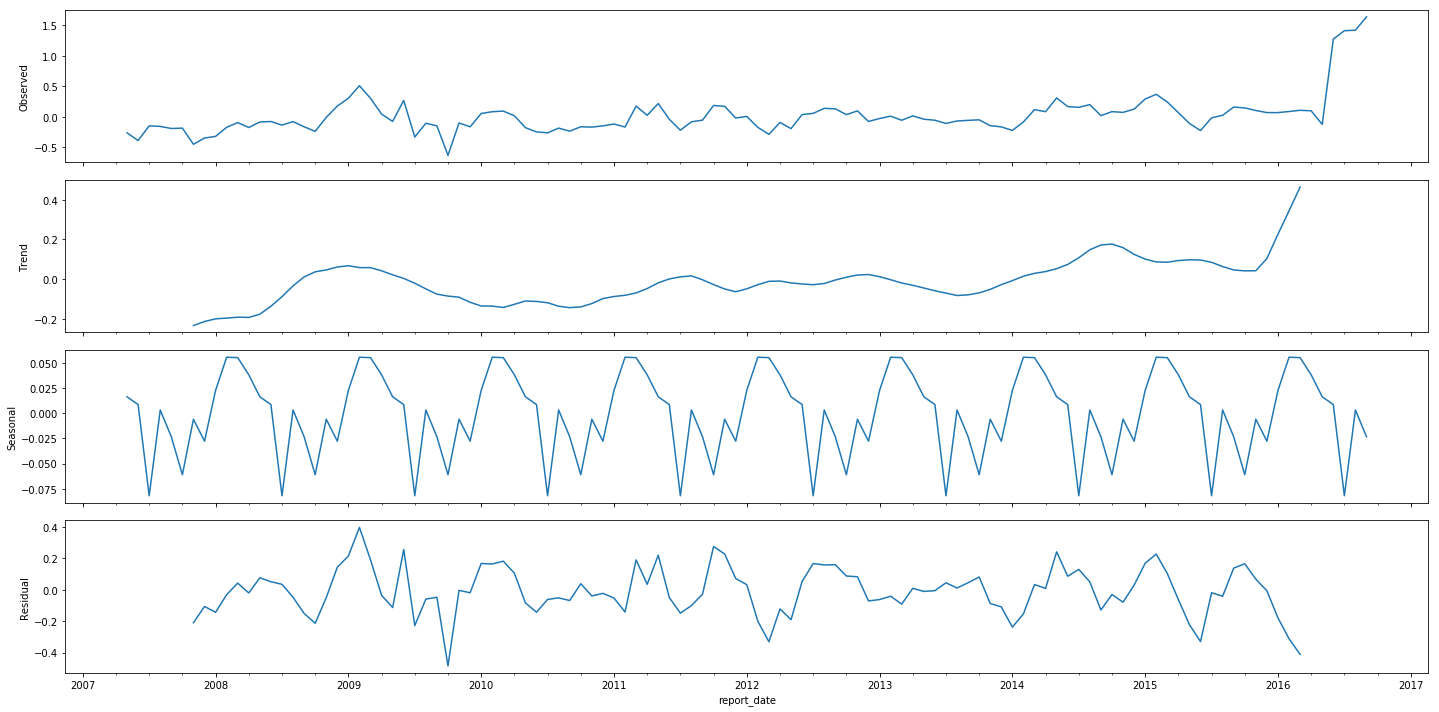

In [17]:
data_vtb['total_amount_log_diff'] = data_vtb.total_amount_log - data_vtb.total_amount_log.shift(4)
rcParams['figure.figsize'] = 20, 10
sm.tsa.seasonal_decompose(data_vtb.total_amount_log_diff.iloc[4:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_vtb.total_amount_log_diff[4:])[1])

Критерий Дики-Фуллера: p=0.017663


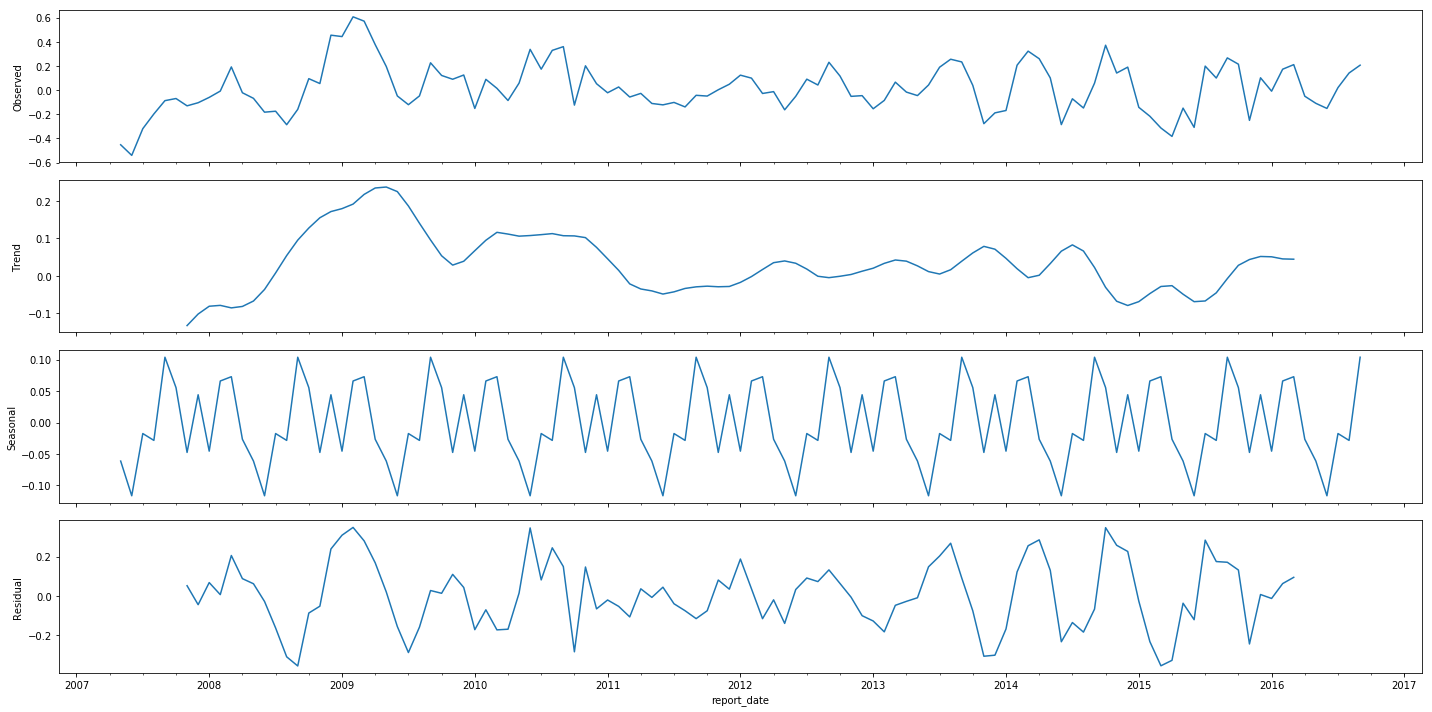

In [18]:
data_unic['total_amount_log_diff'] = data_unic.total_amount_log - data_unic.total_amount_log.shift(4)
rcParams['figure.figsize'] = 20, 10
sm.tsa.seasonal_decompose(data_unic.total_amount_log_diff.iloc[4:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_unic.total_amount_log_diff[4:])[1])

Сезонное дифференцирование хорошо сработало на всех трех рядах, на уровне значимости 0.05 мы можем отвергнуть гипотезы о нестационарности на каждом из рядов.

Далее будем подбирать параметры для построения модели.

Построим автокорреляционную и частичную автокорреляционную функции. 

# Сбер


Сбер


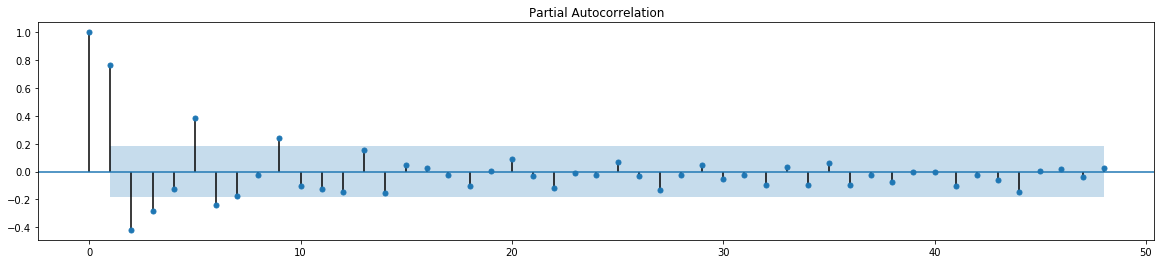

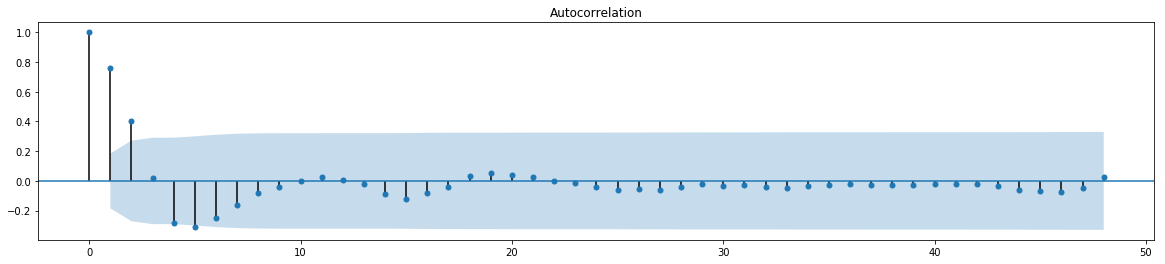

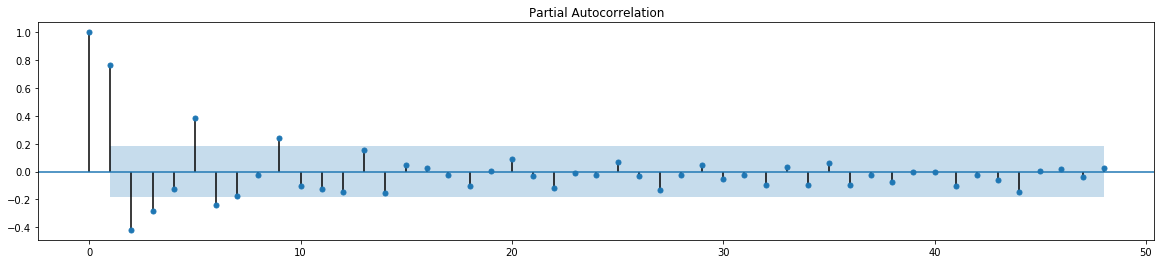

In [19]:
rcParams['figure.figsize'] = 20, 4
print('\nСбер')
sm.graphics.tsa.plot_acf(data_sber.total_amount_log_diff[4:].values.squeeze(), lags=48)
sm.graphics.tsa.plot_pacf(data_sber.total_amount_log_diff[4:].values.squeeze(), lags=48)

Начальные приближения для ряда Сбера: Q=1, q=2, P=1, p=4. Создаю лист параметров.

In [20]:
ps = range(0, 5)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

В каждом датасете имеются пропущенные значения на периоды 2016-11-01 и 2016-12-01. Спрогнозируем их, затем импортируем в датасет (иначе не работает частотность и прогноз не строится).

Для подбора параметров используем критерий Акаике.

In [21]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data_sber.total_amount_log_diff[5:], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
19  (3, 1, 1, 1) -235.583159
22  (4, 0, 1, 1) -234.028716
25  (4, 1, 1, 1) -232.374337
7   (1, 0, 1, 1) -229.429362
16  (3, 0, 1, 1) -229.118209


In [22]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:             total_amount_log_diff   No. Observations:                  112
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 4)   Log Likelihood                 124.792
Date:                           Tue, 14 May 2019   AIC                           -235.583
Time:                                   22:02:49   BIC                           -216.554
Sample:                               07-01-2007   HQIC                          -227.862
                                    - 10-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0427      0.087     12.035      0.000       0.873       1.213
ar.L2         -0.0427      0.123     -0.346

Остатки распределены нормально

Критерий Стьюдента: p= 0.285525
Критерий Дики-Фуллера: p= 0.0017789401830832746


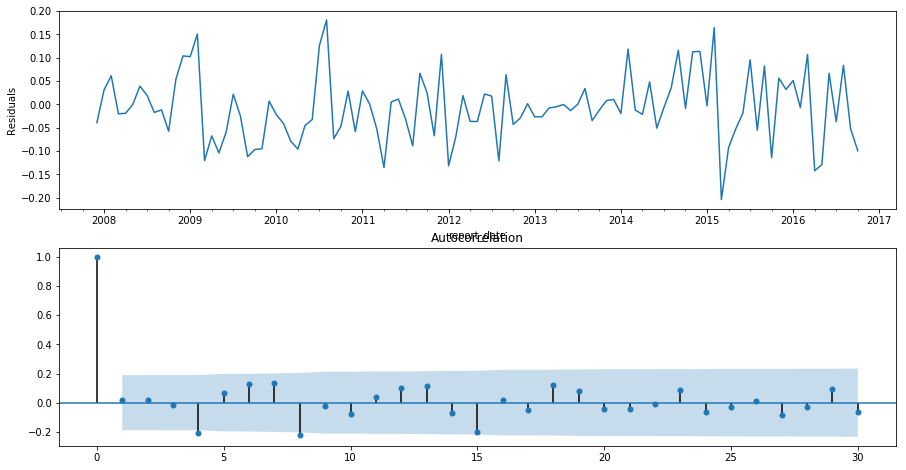

In [23]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[5:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[5:].values.squeeze(), lags=30, ax=ax)

print("Критерий Стьюдента: p= %f" % stats.ttest_1samp(best_model.resid[5:], 0)[1])
p_value = sm.tsa.stattools.adfuller(best_model.resid[5:])[1]
print("Критерий Дики-Фуллера: p=", p_value)

Посмотрим, как модель предсказывает себя

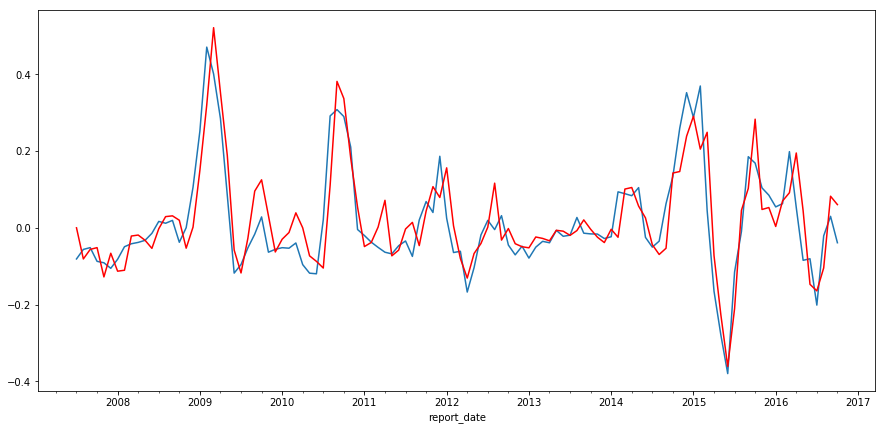

In [24]:
data_sber['model'] = best_model.fittedvalues
plt.figure(figsize=(15,7))
data_sber.total_amount_log_diff[5:].plot()
data_sber.model[5:].plot(color='r')

Прогноз на несколько месяцев вперед

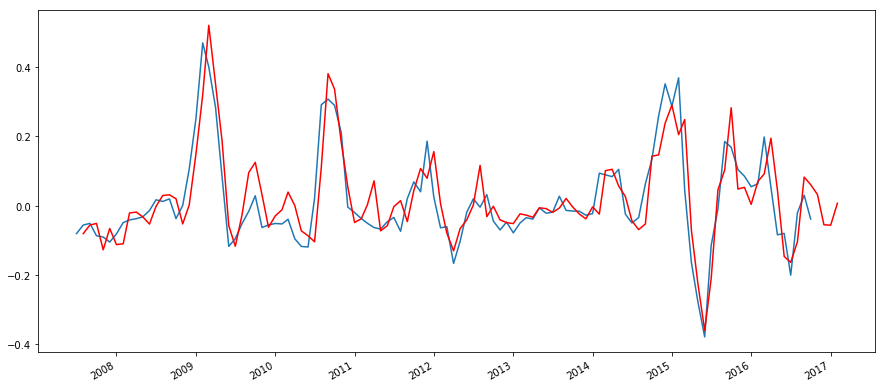

In [25]:
data_sber2 = data_sber[['total_amount_log_diff']]
date_list = [datetime.datetime.strptime("2016-10-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,5)]
future = pd.DataFrame(index=date_list, columns=data_sber2.columns)
data_sber2 = pd.concat([data_sber2, future])

data_sber2['forecast'] = best_model.predict(start='2007-08-01', end='2017-02-01')

plt.figure(figsize=(15,7))
data_sber2.total_amount_log_diff[5:].plot()
data_sber2.forecast.plot(color='r')


# ВТБ


ВТБ


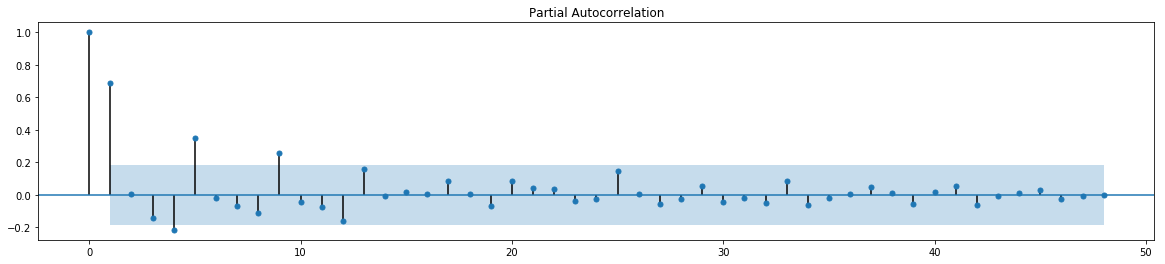

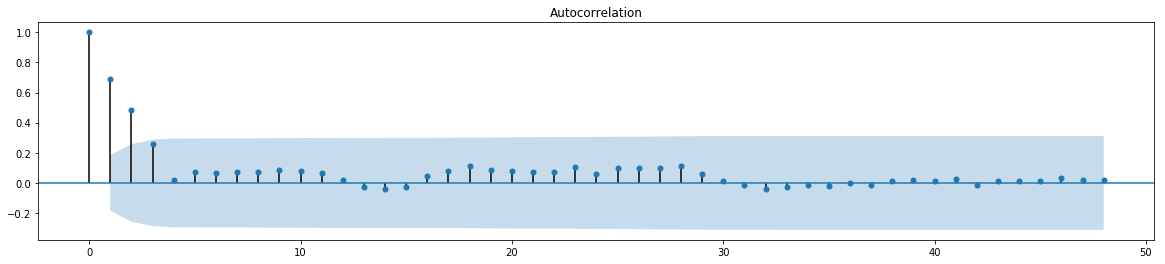

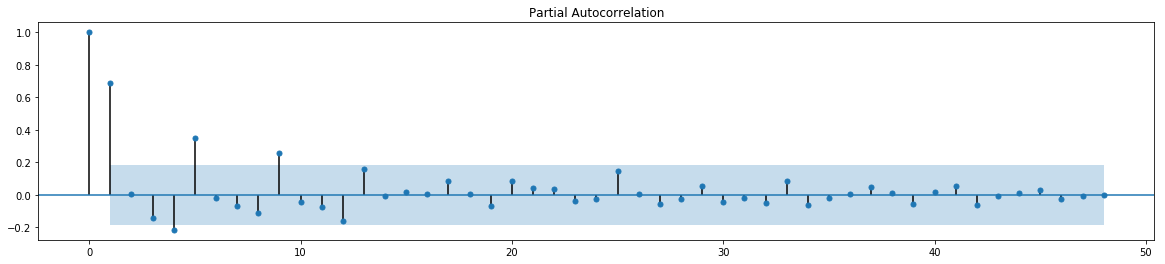

In [26]:
rcParams['figure.figsize'] = 20, 4
print('\nВТБ')
sm.graphics.tsa.plot_acf(data_vtb.total_amount_log_diff[4:].values.squeeze(), lags=48)
sm.graphics.tsa.plot_pacf(data_vtb.total_amount_log_diff[4:].values.squeeze(), lags=48)

Начальные приближения для ряда ВТБ: Q=2, q=2, P=4, p=2. Создаю лист параметров.

In [27]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 4)
D=1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [28]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data_vtb.total_amount_log_diff[5:], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
19  (1, 0, 3, 1) -28.978569
17  (1, 0, 2, 1) -28.872479
12  (0, 1, 3, 1) -28.724630
10  (0, 1, 2, 1) -28.534265
5   (0, 0, 3, 1) -27.575717


In [29]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:             total_amount_log_diff   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(3, 1, 1, 4)   Log Likelihood                  20.489
Date:                           Tue, 14 May 2019   AIC                            -28.979
Time:                                   22:02:56   BIC                            -12.668
Sample:                               06-01-2007   HQIC                           -22.361
                                    - 09-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1791      0.067     -2.666      0.008      -0.311      -0.047
ar.S.L4       -0.6684      0.203     -3.290

Критерий Стьюдента: p= 0.836947
Критерий Дики-Фуллера: p= 9.948017319343754e-19


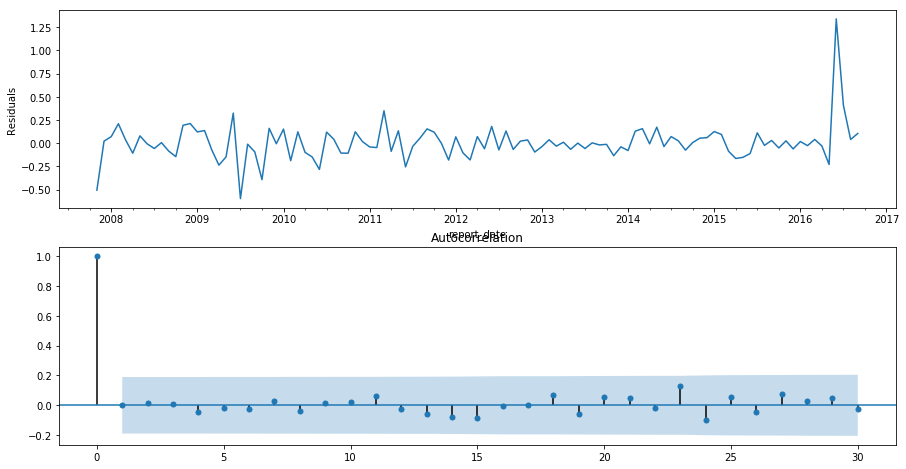

In [30]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[5:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[5:].values.squeeze(), lags=30, ax=ax)

print("Критерий Стьюдента: p= %f" % stats.ttest_1samp(best_model.resid[5:], 0)[1])
p_value = sm.tsa.stattools.adfuller(best_model.resid[5:])[1]
print("Критерий Дики-Фуллера: p=", p_value)

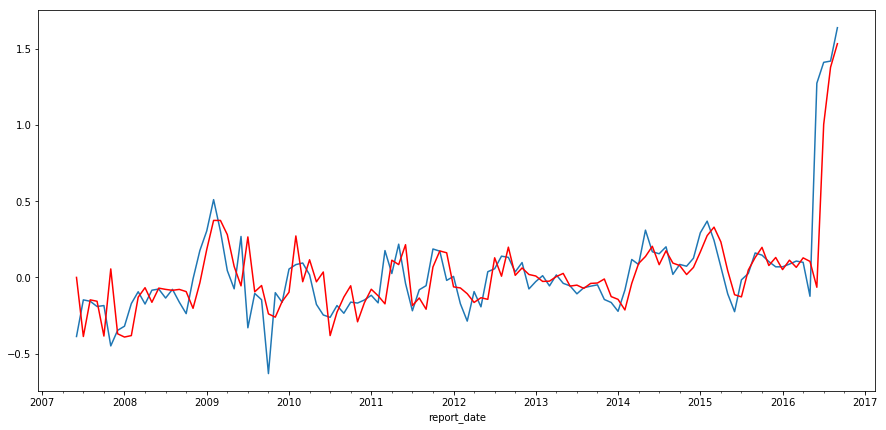

In [31]:
data_vtb['model'] = best_model.fittedvalues
plt.figure(figsize=(15,7))
data_vtb.total_amount_log_diff[5:].plot()
data_vtb.model[5:].plot(color='r')

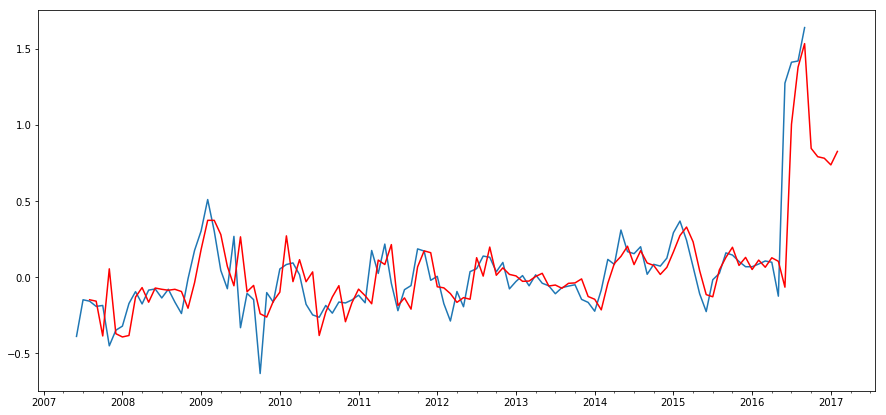

In [32]:
data_vtb2 = data_vtb[['total_amount_log_diff']]
date_list = [datetime.datetime.strptime("2016-10-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,5)]
future = pd.DataFrame(index=date_list, columns=data_vtb2.columns)
data_vtb2 = pd.concat([data_vtb2, future])

data_vtb2['forecast'] = best_model.predict(start='2007-08-01', end='2017-02-01')

plt.figure(figsize=(15,7))
data_vtb2.total_amount_log_diff[5:].plot()
data_vtb2.forecast.plot(color='r')

# Юникредит


Юникредит


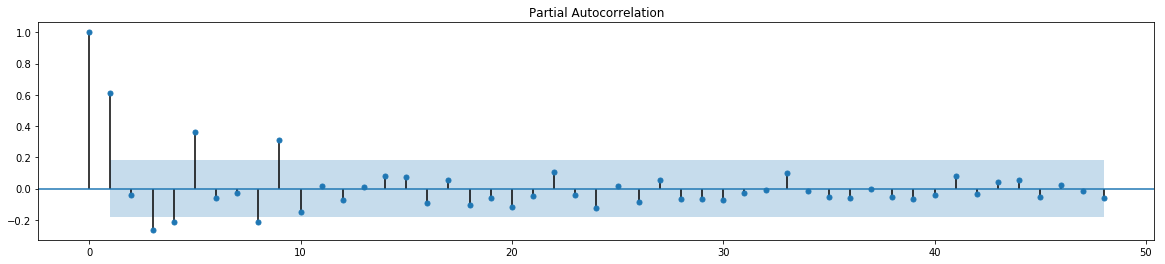

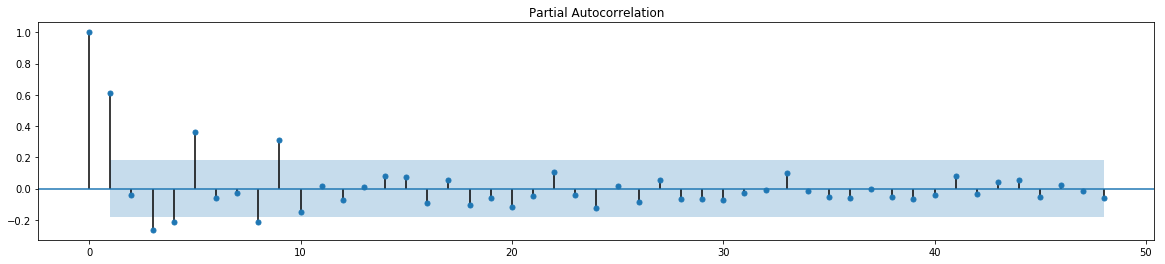

In [33]:
rcParams['figure.figsize'] = 20, 4
print('\nЮникредит')
sm.graphics.tsa.plot_acf(data_unic.total_amount_log_diff[4:].values.squeeze(), lags=48, ax=ax)
sm.graphics.tsa.plot_pacf(data_unic.total_amount_log_diff[4:].values.squeeze(), lags=48)

Начальные приближения для ряда Юникредита: Q=2, q=2, P=4, p=2. Создаю лист параметров.

In [34]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 4)
D=1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [35]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data_unic.total_amount_log_diff[5:], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
16  (1, 0, 3, 1) -103.661963
22  (1, 1, 3, 1) -103.125013
10  (0, 1, 3, 1) -102.922171
14  (1, 0, 2, 1) -101.661059
4   (0, 0, 3, 1) -101.385010


In [36]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:             total_amount_log_diff   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(3, 1, 1, 4)   Log Likelihood                  57.831
Date:                           Tue, 14 May 2019   AIC                           -103.662
Time:                                   22:03:03   BIC                            -87.351
Sample:                               06-01-2007   HQIC                           -97.044
                                    - 09-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2161      0.105     -2.062      0.039      -0.422      -0.011
ar.S.L4       -0.8843      0.087    -10.221

Критерий Стьюдента: p= 0.016243
Критерий Дики-Фуллера: p= 1.1638037950103508e-17


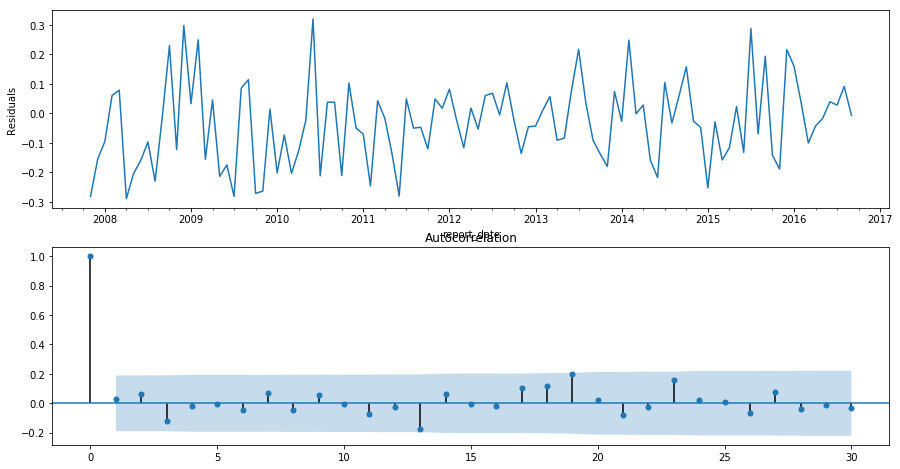

In [37]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[5:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[5:].values.squeeze(), lags=30, ax=ax)

print("Критерий Стьюдента: p= %f" % stats.ttest_1samp(best_model.resid[5:], 0)[1])
p_value = sm.tsa.stattools.adfuller(best_model.resid[5:])[1]
print("Критерий Дики-Фуллера: p=", p_value)

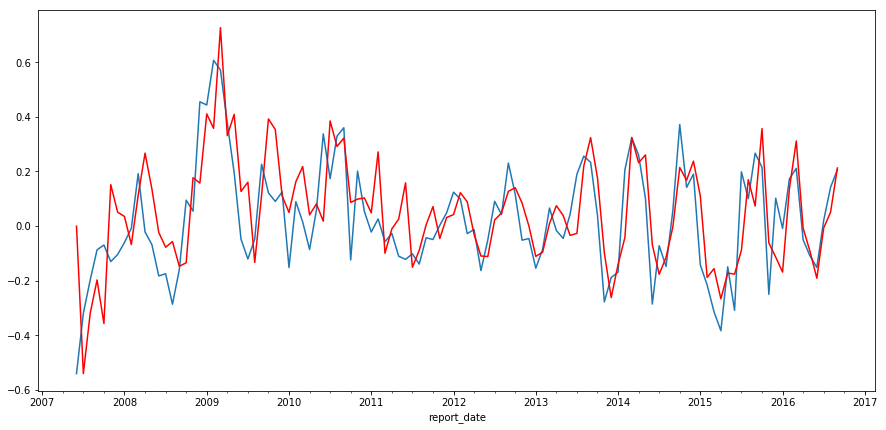

In [38]:
data_unic['model'] = best_model.fittedvalues
plt.figure(figsize=(15,7))
data_unic.total_amount_log_diff[5:].plot()
data_unic.model[5:].plot(color='r')

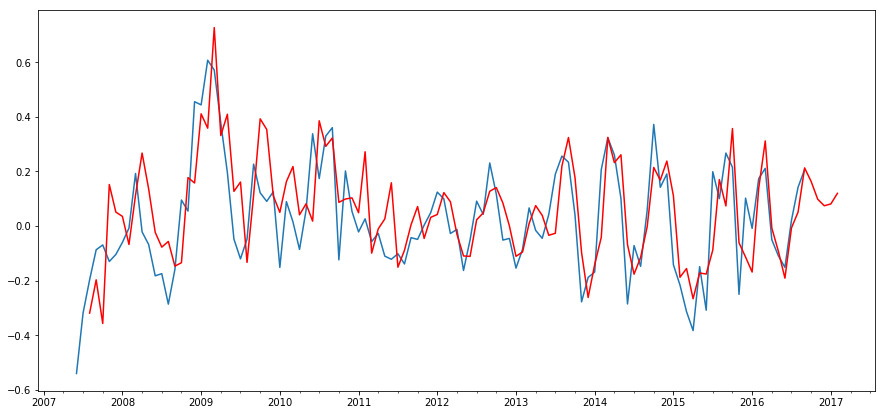

In [39]:
data_unic2 = data_unic[['total_amount_log_diff']]
date_list = [datetime.datetime.strptime("2016-10-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,5)]
future = pd.DataFrame(index=date_list, columns=data_unic2.columns)
data_unic2 = pd.concat([data_unic2, future])

data_unic2['forecast'] = best_model.predict(start='2007-08-01', end='2017-02-01')

plt.figure(figsize=(15,7))
data_unic2.total_amount_log_diff[5:].plot()
data_unic2.forecast.plot(color='r')

# Три графика с предсказаниями и прогнозами

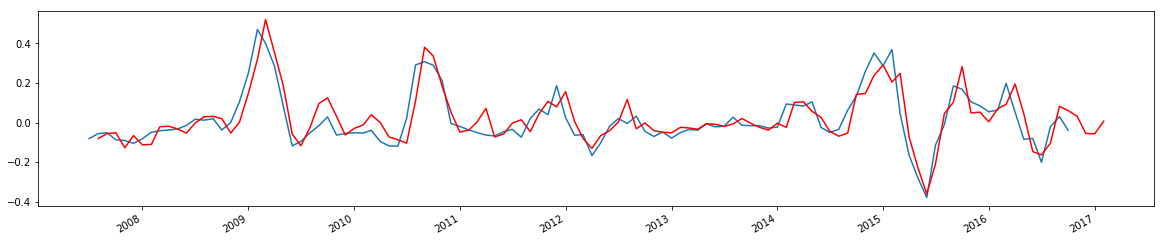

In [40]:
data_sber2.total_amount_log_diff[5:].plot()
data_sber2.forecast.plot(color='r')

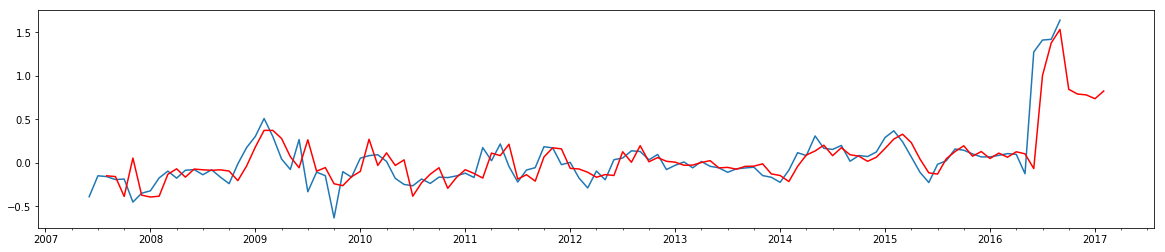

In [41]:
data_vtb2.total_amount_log_diff[5:].plot()
data_vtb2.forecast.plot(color='r')

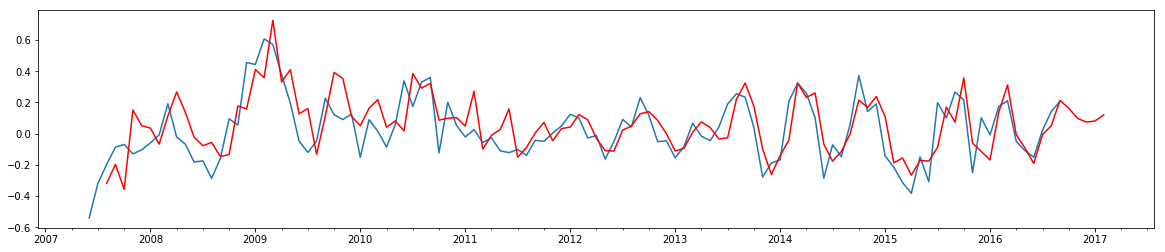

In [42]:
data_unic2.total_amount_log_diff[5:].plot()
data_unic2.forecast.plot(color='r')